In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
import importlib
from libs import models, plots, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)

import pandas as pd
import numpy  as np
import math

import datetime as dt
from datetime import datetime

import copy
from typing import Sequence, List, Tuple, Optional, Union

from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ticker = params.ticker

df = pd.read_csv(f"dfs training/{ticker}_final.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal_scaled,signal_smooth,signal_action
2014-04-03 10:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.398980,0.401385,0
2014-04-03 10:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.400179,0.401989,0
2014-04-03 10:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.401381,0.402595,0
2014-04-03 10:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.402587,0.403201,0
2014-04-03 10:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.403797,0.403809,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.512900,173.617100,-1.4,1.310,0.000000,0.000000,0
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.328000,173.432000,-1.4,1.495,0.000000,0.000000,0
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.258000,173.362000,-1.4,1.565,0.000000,0.000000,0
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.228000,173.332000,-1.4,1.595,0.000000,0.000000,0


In [4]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
label_col      = params.label_col
feature_cols   = params.feature_cols

LOOK_BACK      = params.look_back                                
N_FEATS        = len(feature_cols) 

date = datetime.now().strftime("%Y-%m-%d %H:%M")

regular_start      = params.regular_start_pred

# dataset split proportions
TRAIN_PROP, VAL_PROP = params.train_prop, params.val_prop

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

Using device: cuda


In [5]:
###############################################################################
# 1 · MODEL HYPER-PARAMETERS (attention-augmented tuned defaults)
###############################################################################

# ── Architecture Parameters ───────────────────────────────────────────────
SHORT_UNITS         = 64           # hidden size of each daily LSTM layer
LONG_UNITS          = 128          # hidden size of the weekly LSTM
DROPOUT_SHORT       = 0.3          # dropout after residual+attention block
DROPOUT_LONG        = 0.4          # dropout after weekly LSTM outputs
ATT_HEADS           = 4            # number of self-attention heads
ATT_DROPOUT         = 0.2          # dropout rate inside attention
WEIGHT_DECAY        = 5e-4         # L2 weight decay on all model weights

# ── Training Control Parameters ────────────────────────────────────────────
TRAIN_BATCH         = 32           # days per training bundle
VAL_BATCH           = 1            # days per validation batch
MAX_EPOCHS          = 140          # upper limit on training epochs
EARLY_STOP_PATIENCE = 16           # stop if no val-improve for this many epochs
NUM_WORKERS         = 4            # DataLoader worker count

# ── Optimizer Settings ─────────────────────────────────────────────────────
INITIAL_LR          = 1e-4         # AdamW initial learning rate
CLIPNORM            = 0.5          # max-norm gradient clipping

# ── ReduceLROnPlateau Scheduler ───────────────────────────────────────────
PLATEAU_FACTOR      = 0.3          # multiply LR by this factor on plateau
PLATEAU_PATIENCE    = 5            # epochs with no val-improve before LR cut
MIN_LR              = 1e-6         # lower bound on LR after reductions

# ── CosineAnnealingWarmRestarts Scheduler ─────────────────────────────────
T_0                 = 5           # epochs before first cosine restart
T_MULT              = 1            # cycle length multiplier after each restart
ETA_MIN             = MIN_LR       # floor LR in each cosine cycle


In [6]:
def build_lstm_tensors(
    df: pd.DataFrame,
    *,
    look_back: int,                # number of past minutes used to form each sample
    feature_cols: Sequence[str],   # names of DataFrame columns fed into the LSTM
    label_col: str,                # name of the column to predict (next‐step target)
    regular_start: dt.time,        # only keep windows whose end‐time ≥ this “regular” market open
    device: Optional[torch.device] = None
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Convert a minute‐bar DataFrame into ready‐to‐train PyTorch tensors for a stateful LSTM.
    
    Steps & outputs:
    
      0) Pick your target device (GPU if available, else CPU).
      1) Slice the DataFrame into calendar‐day chunks (so we standardize & state‐reset per day).
      2) For each day:
         a) Sort by timestamp.
         b) Extract raw price series (close, bid, ask) as CPU tensors.
         c) Standardize your chosen feature columns with a fresh StandardScaler.
         d) Build sliding windows of length `look_back` via `Tensor.unfold`.
         e) Align next‐minute labels (`label_col`) and raw‐price points by dropping the first `look_back` rows.
         f) Mask out any windows whose *end* timestamp is before `regular_start`.
      3) Concatenate all days’ windows, labels, and raw‐price arrays along the sample dimension.
      4) Move everything onto the target device exactly once.

    Returns:
      X         – float32 Tensor of shape (N, look_back, F), the standardized input windows
      y         – float32 Tensor of shape (N,       ), the aligned single‐step targets
      raw_close – float32 Tensor of shape (N,       ), the raw close price at prediction time
      raw_bid   – float32 Tensor of shape (N,       ), the raw bid   price at prediction time
      raw_ask   – float32 Tensor of shape (N,       ), the raw ask   price at prediction time

    Where:
      N = total number of windows across all days that passed the RTH filter,
      F = number of feature columns,
      look_back = number of minutes in each input window.
    """

    # Prepare per-day lists (CPU‐resident) to collect windows & labels
    X_days, y_days = [], []
    c_days, b_days, a_days = [], [], []  # raw close/bid/ask

    # 1) Loop over each calendar day chunk
    #    df.index.normalize() groups by midnight‐normalized date
    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        # Ensure chronological order
        day_df = day_df.sort_index()

        # 1a) Raw price series as 1D CPU Tensors (length T = # minutes in the day)
        close_t = torch.from_numpy(
            day_df["close"].to_numpy(dtype=np.float32)
        )  # shape: (T,)
        bid_t = torch.from_numpy(
            day_df["bid"].to_numpy(dtype=np.float32)
        )
        ask_t = torch.from_numpy(
            day_df["ask"].to_numpy(dtype=np.float32)
        )

        # 1b) Standardize features *per day* on CPU
        #     - fit_transform ensures zero‐mean, unit‐variance per-day
        feats_np = StandardScaler().fit_transform(
            day_df[feature_cols].to_numpy()
        )           # shape: (T, F)
        feats_t = torch.from_numpy(feats_np.astype(np.float32))

        # 1c) Raw labels (next‐step targets) as CPU Tensor
        labels_t = torch.from_numpy(
            day_df[label_col].to_numpy(dtype=np.float32)
        )  # shape: (T,)

        # 2) Build sliding windows (unfold on the time axis)
        #    Tensor.unfold(dim=0, size=look_back, step=1) 
        #    produces shape (T - look_back + 1, look_back, F)
        windows = feats_t.unfold(0, look_back, 1)

        # 3) Align targets one step *after* each window:
        #    - Drop the final window so that `targets = labels_t[look_back:]` aligns 1:1
        windows = windows[:-1]               # new shape: (T - look_back, look_back, F)
        targets = labels_t[look_back:]       # shape: (T - look_back,)
        c_pts = close_t[look_back:]          # raw close aligned
        b_pts = bid_t[look_back:]            # raw bid aligned
        a_pts = ask_t[look_back:]            # raw ask aligned

        # 4) RTH filtering: only keep windows whose *end* timestamp is ≥ regular_start
        #    day_df.index.time[look_back:] is a numpy array of length (T - look_back)
        end_times = day_df.index.time[look_back:]
        mask = (end_times >= regular_start)     # boolean mask, shape=(T - look_back,)
        if not np.any(mask):
            # no windows qualify for this day → skip
            continue

        # Convert numpy bool mask into a torch.BoolTensor
        mask_t = torch.from_numpy(mask)

        # 5) Apply mask to CPU tensors (window‐batch dim is dimension 0)
        windows = windows[mask_t]            # (n_i, look_back, F)
        targets = targets[mask_t]            # (n_i,)
        c_pts = c_pts[mask_t]                # (n_i,)
        b_pts = b_pts[mask_t]                # (n_i,)
        a_pts = a_pts[mask_t]                # (n_i,)

        # 6) Collect this day’s filtered windows & labels
        X_days.append(windows)
        y_days.append(targets)
        c_days.append(c_pts)
        b_days.append(b_pts)
        a_days.append(a_pts)

    # If after filtering no windows remain, alert the user
    if not X_days:
        raise ValueError(
            "No windows passed RTH filter; check your regular_start or input DataFrame."
        )

    # 7) Concatenate all days along the sample dimension (dim=0) on CPU
    X_cpu = torch.cat(X_days, dim=0)   # final shape: (N, look_back, F)
    y_cpu = torch.cat(y_days, dim=0)   # final shape: (N,)
    c_cpu = torch.cat(c_days, dim=0)   # final shape: (N,)
    b_cpu = torch.cat(b_days, dim=0)   # final shape: (N,)
    a_cpu = torch.cat(a_days, dim=0)   # final shape: (N,)

    # 8) One‐shot transfer to the chosen device for fastest GPU memory copy
    #    non_blocking=True overlaps host→device copies with compute when possible.
    X         = X_cpu.to(device, non_blocking=True)
    y         = y_cpu.to(device, non_blocking=True)
    raw_close = c_cpu.to(device, non_blocking=True)
    raw_bid   = b_cpu.to(device, non_blocking=True)
    raw_ask   = a_cpu.to(device, non_blocking=True)

    return X, y, raw_close, raw_bid, raw_ask


In [7]:
X, y, raw_close, raw_bid, raw_ask = build_lstm_tensors(
    df=df,
    look_back=LOOK_BACK,
    feature_cols=feature_cols,
    label_col=label_col,
    regular_start=regular_start
)

# 1)
print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) 


# 2) quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

# 3) rebuild the list of label‐timestamps (window‐ends)
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    day_df = day_df.sort_index()
    # candidate ends at positions look_back .. end
    idxs = day_df.index[LOOK_BACK:]
    # only keep those at/after regular_start
    mask = [t >= regular_start for t in idxs.time]
    ends.extend(idxs[mask])

# 4) show first few ends
print("\nFirst 5 window‐end timestamps:")
for ts in ends[:5]:
    print(" ", ts)

# 5) show exactly which minutes X[0] contains
first_end   = ends[0]
first_start = first_end - pd.Timedelta(minutes=LOOK_BACK)
print(f"\nFirst window covers {LOOK_BACK} bars from")
print(f"  {first_start}  →  {first_end - pd.Timedelta(minutes=1)}")
print(f"and predicts the bar at {first_end}")

print("\nThose bars (timestamps):")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
# -------------------------------------------------------------------

y_np         = y.cpu().numpy()
print("First 5 values y:",         y_np[:5])
print("First 5 signal_smooth values, on regular trade time:")
df.signal_smooth.iloc[LOOK_BACK:LOOK_BACK+5]

torch.Size([1438976, 5, 120])
torch.Size([1438976])
Shapes:
  X         = torch.Size([1438976, 5, 120]) (samples, look_back, features)
  y         = torch.Size([1438976]) (samples,)
  raw_close = torch.Size([1438976])
  raw_bid   = torch.Size([1438976])
  raw_ask   = torch.Size([1438976])

First 5 window‐end timestamps:
  2014-04-03 12:30:00
  2014-04-03 12:31:00
  2014-04-03 12:32:00
  2014-04-03 12:33:00
  2014-04-03 12:34:00

First window covers 120 bars from
  2014-04-03 10:30:00  →  2014-04-03 12:29:00
and predicts the bar at 2014-04-03 12:30:00

Those bars (timestamps):
DatetimeIndex(['2014-04-03 10:30:00', '2014-04-03 10:31:00',
               '2014-04-03 10:32:00', '2014-04-03 10:33:00',
               '2014-04-03 10:34:00', '2014-04-03 10:35:00',
               '2014-04-03 10:36:00', '2014-04-03 10:37:00',
               '2014-04-03 10:38:00', '2014-04-03 10:39:00',
               ...
               '2014-04-03 12:20:00', '2014-04-03 12:21:00',
               '2014-04-03 12:22

2014-04-03 12:30:00    0.674678
2014-04-03 12:31:00    0.680113
2014-04-03 12:32:00    0.684745
2014-04-03 12:33:00    0.688568
2014-04-03 12:34:00    0.691578
Name: signal_smooth, dtype: float64

In [8]:
def chronological_split(
    X: torch.Tensor, 
    y: torch.Tensor,
    raw_close: torch.Tensor,
    raw_bid:   torch.Tensor,
    raw_ask:   torch.Tensor,
    df:        pd.DataFrame,
    *,
    look_back:      int,          # how many minutes each input window spans
    regular_start:  dt.time,      # earliest timestamp at which we make predictions each day
    train_prop:     float,        # fraction of calendar days for training
    val_prop:       float,        # fraction of calendar days for validation
    train_batch:    int,          # round-up granularity for training days
    device:         Optional[torch.device] = None
) -> Tuple[
    Tuple[torch.Tensor, torch.Tensor],                                   # (X_tr, y_tr)
    Tuple[torch.Tensor, torch.Tensor],                                   # (X_val, y_val)
    Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],  # (X_te, y_te, close_te, bid_te, ask_te)
    List[int],                                                           # samples_per_day
    torch.Tensor, torch.Tensor, torch.Tensor                              # day_id_tr, day_id_val, day_id_te
]:
    """
    Splits a monolithic sliding‐window dataset into chronological train/val/test
    groups by calendar day.  Ensures that *no day’s* windows end up in more than
    one split.  Returns the per‐split tensors plus metadata, and also writes
    out the full-minute test‐period DataFrame to CSV.

    Args:
      X           Tensor of all windows, shape (N, look_back, F)
      y           Tensor of all labels,  shape (N,)
      raw_close   Raw close‐price at prediction times, shape (N,)
      raw_bid     Raw bid‐price at prediction times,   shape (N,)
      raw_ask     Raw ask‐price at prediction times,   shape (N,)
      df          Original minute‐bar DataFrame (DatetimeIndex)

    Returns:
      - (X_tr, y_tr)
      - (X_val, y_val)
      - (X_te, y_te, close_te, bid_te, ask_te)
      - samples_per_day  (list of # windows contributed by each day)
      - day_id_tr, day_id_val, day_id_te  (per-window day‐index tags)
    """

    # 0) Default device: if none provided, use X’s device
    device = device or X.device

    # 1) Count valid windows per calendar day
    samples_per_day: List[int] = []
    # also record the ordered list of calendar‐day dates
    all_days: List[pd.Timestamp] = []

    for day, day_df in df.groupby(df.index.normalize(), sort=False):
        all_days.append(day)
        day_df = day_df.sort_index()
        # candidate window‐ends at positions look_back .. end
        end_times = day_df.index.time[look_back:]
        # mask True for windows whose end‐time ≥ market-open
        mask_rth = np.array([t >= regular_start for t in end_times], dtype=bool)
        samples_per_day.append(int(mask_rth.sum()))

    # 2) Sanity: total windows must match X.shape[0]
    total = sum(samples_per_day)
    if total != X.size(0):
        raise ValueError(f"Window count mismatch: {total} vs {X.size(0)}")

    # 3) Build a day‐ID tensor tagging each window by its day index [0..D-1]
    D = len(samples_per_day)
    day_counts = torch.tensor(samples_per_day, dtype=torch.long, device=device)
    day_id_vec = torch.repeat_interleave(
        torch.arange(D, device=device, dtype=torch.long),
        day_counts
    )  # shape = (N,)

    # 4) Compute train/val/test cutoffs in day‐space
    train_days_orig = int(D * train_prop)
    batches_needed  = (train_days_orig + train_batch - 1) // train_batch
    train_days      = min(D, batches_needed * train_batch)
    cut_train       = train_days - 1
    cut_val         = int(D * (train_prop + val_prop))

    # 5) Make boolean masks over the N windows
    mask_tr  = day_id_vec <= cut_train
    mask_val = (day_id_vec > cut_train) & (day_id_vec <= cut_val)
    mask_te  = day_id_vec > cut_val

    # 6) Slice out train/val/test tensors
    X_tr, y_tr   = X[mask_tr],       y[mask_tr]
    X_val, y_val = X[mask_val],      y[mask_val]
    X_te,  y_te  = X[mask_te],       y[mask_te]
    close_te     = raw_close[mask_te]
    bid_te       = raw_bid[mask_te]
    ask_te       = raw_ask[mask_te]

    # 7) Also slice out the per-window day IDs
    day_id_tr  = day_id_vec[mask_tr]
    day_id_val = day_id_vec[mask_val]
    day_id_te  = day_id_vec[mask_te]

    # ────────────────────────────────────────────────────────────────────
    # SIDE‐EFFECT: write out just the regular‐session bars for test days
    test_days = [all_days[i] for i in range(D) if i > cut_val]
    df_test=df.loc[df.index.normalize().isin(test_days)]
    # Save to disk for downstream use
    df_test.to_csv(f"dfs training/{ticker}_test_DF.csv", index=True)

    # 8) Return splits + metadata
    return (
        (X_tr, y_tr),
        (X_val, y_val),
        (X_te, y_te, close_te, bid_te, ask_te),
        samples_per_day,
        day_id_tr, day_id_val, day_id_te
    )


In [9]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = LOOK_BACK,
    regular_start   = regular_start,
    train_prop  = TRAIN_PROP,
    val_prop    = VAL_PROP,
    train_batch = TRAIN_BATCH
)

# 1) Print shapes of all tensors
print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)

# 2) Print number of days in each split
n_tr_days = torch.unique(day_id_tr).numel()
n_val_days= torch.unique(day_id_val).numel()
n_te_days = torch.unique(day_id_te).numel()
print(f"\nDays: train={n_tr_days}, val={n_val_days}, test={n_te_days}")

# 3) Print number of windows in each split
print(f"Windows: train={X_tr.shape[0]}, val={X_val.shape[0]}, test={X_te.shape[0]}")

# 4) List the first few window‐end timestamps
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    ts = day_df.index[LOOK_BACK:]
    ends.extend(ts[ts.time >= regular_start])
first_ends = ends[:5]
print("\nFirst 5 window‐end times:", first_ends)

# 5) Show exactly which minutes X_tr[0] covers, and where y_tr[0] sits
first_end   = first_ends[0]
first_start = first_end - pd.Timedelta(minutes=LOOK_BACK)
# input bars = [first_start … first_end − 1min]
print(f"\nX_tr[0] covers bars from {first_start} to {first_end - pd.Timedelta(minutes=1)}")
print("Those timestamps:")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
print(f"y_tr[0] (and raw_close_te[0]) is the bar at {first_end}")



Shapes:
  X_tr        = torch.Size([1013824, 5, 120])
  y_tr        = torch.Size([1013824])
  raw_close_te= torch.Size([215642])
  raw_bid_te  = torch.Size([215642])
  raw_ask_te  = torch.Size([215642])

Days: train=1984, val=410, test=422
Windows: train=1013824, val=209510, test=215642

First 5 window‐end times: [Timestamp('2014-04-03 12:30:00'), Timestamp('2014-04-03 12:31:00'), Timestamp('2014-04-03 12:32:00'), Timestamp('2014-04-03 12:33:00'), Timestamp('2014-04-03 12:34:00')]

X_tr[0] covers bars from 2014-04-03 10:30:00 to 2014-04-03 12:29:00
Those timestamps:
DatetimeIndex(['2014-04-03 10:30:00', '2014-04-03 10:31:00',
               '2014-04-03 10:32:00', '2014-04-03 10:33:00',
               '2014-04-03 10:34:00', '2014-04-03 10:35:00',
               '2014-04-03 10:36:00', '2014-04-03 10:37:00',
               '2014-04-03 10:38:00', '2014-04-03 10:39:00',
               ...
               '2014-04-03 12:20:00', '2014-04-03 12:21:00',
               '2014-04-03 12:22:00', '201

In [10]:

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=TRAIN_BATCH
)


In [11]:

def make_optimizer_and_scheduler(
    model: nn.Module,
    initial_lr: float,
    weight_decay: float = 1e-3,
    lr_reduce_factor: float = 0.5,
    lr_patience: int = 3,
    lr_min: float = 1e-6,
    clipnorm: float = 0.5,
):
    """
    Build optimizer, LR scheduler, AMP scaler, and clipping threshold.

    • optimizer: AdamW with L2 weight_decay on all non‐bias weights.
    • plateau_sched: ReduceLROnPlateau – watches val‐RMSE, cuts LR when plateau.
      - mode='min'       → lower-is-better metric (we minimize RMSE).
      - factor=0.5       → multiply LR by 0.5 on plateau.
      - patience=3       → wait 3 epochs with no improvement before cutting.
      - min_lr=1e-6      → never drop below this learning rate.
      - verbose=True     → print a message whenever LR is reduced.
    • scaler: GradScaler for mixed‐precision (automatically handles device).
    • clipnorm: float threshold for gradient clipping in train_step.

    Returns:
      optimizer, plateau_sched, scaler, clipnorm
    """
    # 1) AdamW: adaptive moment optimizer with decoupled weight decay
    optimizer = AdamW(
        model.parameters(),
        lr=initial_lr,
        weight_decay=weight_decay
    )

    # 2) ReduceLROnPlateau: only reduces LR when val metric plateaus
    plateau_sched = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_reduce_factor,
        patience=lr_patience,
        min_lr=lr_min,
        verbose=True
    )

    cosine_sched  = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=T_0, 
        T_mult=T_MULT, 
        eta_min=ETA_MIN
    )

    # 3) GradScaler: handles loss scaling for mixed precision
    scaler = GradScaler()

    # Return all four objects; clipnorm passed through to train_step
    return optimizer, plateau_sched, cosine_sched, scaler, clipnorm



def train_step(
    model:     nn.Module,
    x_day:     torch.Tensor,            # shape (W, look_back, F), already on device
    y_day:     torch.Tensor,            # shape (W,),            already on device
    optimizer: torch.optim.Optimizer,
    scaler:    GradScaler,
    clipnorm:  float,
) -> float:
    """
    Perform one mixed‐precision training update for a single “day” of data.

    Steps:
      1. Zero gradients (`optimizer.zero_grad(set_to_none=True)`).
      2. Forward in fp16 context:
         - autocast on x_day.device
         - model(x_day) → out shape (W, seq_len, 1)
         - extract last step: out[:, -1, 0] → (W,)
         - compute MSE loss against y_day
      3. Backward:
         - scaler.scale(loss).backward()
         - scaler.unscale_(optimizer) to prepare for clipping
         - clip gradients to `clipnorm`
         - scaler.step(optimizer) + scaler.update()
      4. Return float(loss)

    Returns:
      The scalar loss value (Python float) for logging.
    """
    # 1) Reset gradients
    optimizer.zero_grad(set_to_none=True)
    model.train()

    # 2) Mixed‐precision forward
    device = x_day.device
    with autocast(device_type=device.type):
        out = model(x_day)            # → (W, seq_len, 1)
        last = out[:, -1, 0]          # → (W,)
        loss = Funct.mse_loss(last, y_day, reduction='mean')

    # 3) Backward with gradient scaling and clipping
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)        # bring gradients back to fp32 for clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
    scaler.step(optimizer)
    scaler.update()

    return loss.item()


def get_current_lr(optimizer: torch.optim.Optimizer) -> float:
    """
    Retrieve the current learning rate from the first parameter group.
    """
    return float(optimizer.param_groups[0]['lr'])


In [12]:

def custom_stateful_training_loop(
    model:         torch.nn.Module,
    optimizer:     torch.optim.Optimizer,
    cosine_sched:  torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    plateau_sched: torch.optim.lr_scheduler.ReduceLROnPlateau,
    scaler:        torch.cuda.amp.GradScaler,
    train_loader:  torch.utils.data.DataLoader,
    val_loader:    torch.utils.data.DataLoader,
    *,
    max_epochs:          int,
    early_stop_patience: int,
    baseline_val_rmse:   float,
    clipnorm:            float,
    device:              torch.device
) -> float:
    """
    Training loop with:
      - mixed precision
      - per-day / per-week LSTM resets
      - CosineAnnealingWarmRestarts (per-batch)
      - ReduceLROnPlateau (per-epoch, on val RMSE)
      - live RMSE plotting & early stop
    """
    model.to(device)
    torch.backends.cudnn.benchmark = True

    # Track the best validation RMSE and store its weights
    best_val_rmse = float('inf')
    best_state    = None
    patience_ctr  = 0

    save_path = params.save_path
    save_path.mkdir(parents=True, exist_ok=True)
    live_plot = plots.LiveRMSEPlot()

    for epoch in range(1, max_epochs + 1):
        # ─── TRAIN ───────────────────────────────────────────
        model.train()
        model.h_short = model.h_long = None
        train_losses = []

        # enumerate so we can step cosine_sched per-batch
        pbar = tqdm(
            enumerate(train_loader, start=0),
            total = len(train_loader),
            desc  = f"Epoch {epoch}",
            unit  = "bundle"
        )

        for batch_idx, (xb_days, yb_days, wd_days) in pbar:
            xb_days = xb_days.to(device, non_blocking=True)
            yb_days = yb_days.to(device, non_blocking=True)
            wd_days = wd_days.to(device)

            prev_wd = None
            # loop over each day in this bundle
            for di in range(xb_days.size(0)):
                wd = int(wd_days[di].item())

                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                loss_val = train_step(
                    model,
                    xb_days[di],   # (W, look_back, F)
                    yb_days[di],   # (W,)
                    optimizer,
                    scaler,
                    clipnorm
                )
                train_losses.append(loss_val)

            # step the cosine‐warm‐restart scheduler
            frac_epoch = epoch - 1 + batch_idx / len(train_loader)
            cosine_sched.step(frac_epoch)

            # update progress bar
            rmse = math.sqrt(sum(train_losses) / len(train_losses))
            lr   = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_rmse=rmse, lr=lr, refresh=False)

        pbar.close()

        # ─── VALIDATE ─────────────────────────────────────────
        model.eval()
        model.h_short = model.h_long = None
        val_losses = []
        prev_wd    = None

        with torch.no_grad():
            for xb_day, yb_day, wd in val_loader:
                wd = int(wd.item())
                x  = xb_day[0].to(device, non_blocking=True)  # (W, look_back, F)
                y  = yb_day.view(-1).to(device, non_blocking=True)  # (W,)

                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                out  = model(x)               # (W, look_back, 1)
                last = out[:, -1, 0]          # (W,)
                val_losses.append(Funct.mse_loss(last, y, reduction='mean').item())

        val_rmse = math.sqrt(sum(val_losses) / len(val_losses))

        # ─── LOG & PLOT ───────────────────────────────────────
        live_plot.update(rmse, val_rmse)
        print(f"Epoch {epoch:03d} • train={rmse:.4f} • val={val_rmse:.4f} • lr={optimizer.param_groups[0]['lr']:.2e}")

        # ─── PLATEAU STEP ─────────────────────────────────────
        pre_lr = optimizer.param_groups[0]['lr']
        plateau_sched.step(val_rmse)
        post_lr = optimizer.param_groups[0]['lr']
        if post_lr < pre_lr:
            print(f"Plateau reduced LR: {pre_lr:.1e} → {post_lr:.1e} at epoch {epoch}")

        # ─── EARLY STOPPING & BEST‐STATE SNAPSHOT ─────────────
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_ctr  = 0
            # save the weights from this best epoch
            best_state = copy.deepcopy(model.state_dict())
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # ─── SAVE THE SINGLE BEST MODEL ────────────────────────
    ckpt_file = save_path / f"{ticker}_{best_val_rmse:.4f}.pth"
    if best_state is not None:
        # load best epoch's weights back into model
        model.load_state_dict(best_state)
    torch.save(model, ckpt_file)
    print(f"Saved best model (val RMSE={best_val_rmse:.4f}) to {ckpt_file}")

    return best_val_rmse


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training sees 1984 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.426896


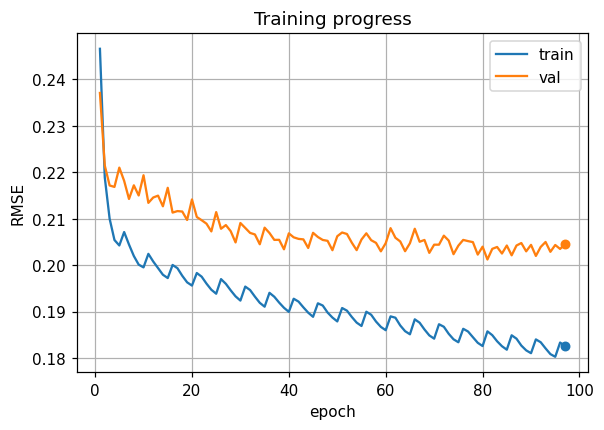

Epoch 1: 100%|██████████| 62/62 [00:31<00:00,  1.99bundle/s, lr=9.08e-5, train_rmse=0.247]


Epoch 001 • train=0.2466 • val=0.2371 • lr=9.08e-05


Epoch 2: 100%|██████████| 62/62 [00:28<00:00,  2.20bundle/s, lr=6.63e-5, train_rmse=0.219]


Epoch 002 • train=0.2189 • val=0.2215 • lr=6.63e-05


Epoch 3: 100%|██████████| 62/62 [00:29<00:00,  2.12bundle/s, lr=3.57e-5, train_rmse=0.21] 


Epoch 003 • train=0.2100 • val=0.2172 • lr=3.57e-05


Epoch 4: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1.08e-5, train_rmse=0.205]


Epoch 004 • train=0.2054 • val=0.2169 • lr=1.08e-05


Epoch 5: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=1e-6, train_rmse=0.204]   


Epoch 005 • train=0.2043 • val=0.2210 • lr=1.00e-06


Epoch 6: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.207]


Epoch 006 • train=0.2071 • val=0.2182 • lr=9.08e-05


Epoch 7: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=6.63e-5, train_rmse=0.204]


Epoch 007 • train=0.2044 • val=0.2143 • lr=6.63e-05


Epoch 8: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=3.57e-5, train_rmse=0.202]


Epoch 008 • train=0.2020 • val=0.2172 • lr=3.57e-05


Epoch 9: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=1.08e-5, train_rmse=0.2]  


Epoch 009 • train=0.2001 • val=0.2150 • lr=1.08e-05


Epoch 10: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1e-6, train_rmse=0.2]     


Epoch 010 • train=0.1995 • val=0.2194 • lr=1.00e-06


Epoch 11: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.202]


Epoch 011 • train=0.2024 • val=0.2134 • lr=9.08e-05


Epoch 12: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=6.63e-5, train_rmse=0.201]


Epoch 012 • train=0.2008 • val=0.2146 • lr=6.63e-05


Epoch 13: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=3.57e-5, train_rmse=0.199]


Epoch 013 • train=0.1994 • val=0.2150 • lr=3.57e-05


Epoch 14: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1.08e-5, train_rmse=0.198]


Epoch 014 • train=0.1979 • val=0.2127 • lr=1.08e-05


Epoch 15: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1e-6, train_rmse=0.197]   


Epoch 015 • train=0.1972 • val=0.2167 • lr=1.00e-06


Epoch 16: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=9.08e-5, train_rmse=0.2]  


Epoch 016 • train=0.2000 • val=0.2113 • lr=9.08e-05


Epoch 17: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=6.63e-5, train_rmse=0.199]


Epoch 017 • train=0.1994 • val=0.2117 • lr=6.63e-05


Epoch 18: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=3.57e-5, train_rmse=0.198]


Epoch 018 • train=0.1977 • val=0.2116 • lr=3.57e-05


Epoch 19: 100%|██████████| 62/62 [00:30<00:00,  2.06bundle/s, lr=1.08e-5, train_rmse=0.196]


Epoch 019 • train=0.1963 • val=0.2097 • lr=1.08e-05


Epoch 20: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=1e-6, train_rmse=0.196]   


Epoch 020 • train=0.1956 • val=0.2142 • lr=1.00e-06


Epoch 21: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.198]


Epoch 021 • train=0.1983 • val=0.2104 • lr=9.08e-05


Epoch 22: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=6.63e-5, train_rmse=0.198]


Epoch 022 • train=0.1975 • val=0.2097 • lr=6.63e-05


Epoch 23: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=3.57e-5, train_rmse=0.196]


Epoch 023 • train=0.1960 • val=0.2089 • lr=3.57e-05


Epoch 24: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1.08e-5, train_rmse=0.195]


Epoch 024 • train=0.1947 • val=0.2073 • lr=1.08e-05


Epoch 25: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1e-6, train_rmse=0.194]   


Epoch 025 • train=0.1939 • val=0.2114 • lr=1.00e-06


Epoch 26: 100%|██████████| 62/62 [00:28<00:00,  2.16bundle/s, lr=9.08e-5, train_rmse=0.197]


Epoch 026 • train=0.1970 • val=0.2078 • lr=9.08e-05


Epoch 27: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=6.63e-5, train_rmse=0.196]


Epoch 027 • train=0.1960 • val=0.2086 • lr=6.63e-05


Epoch 28: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=3.57e-5, train_rmse=0.195]


Epoch 028 • train=0.1946 • val=0.2073 • lr=3.57e-05


Epoch 29: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1.08e-5, train_rmse=0.193]


Epoch 029 • train=0.1933 • val=0.2049 • lr=1.08e-05


Epoch 30: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1e-6, train_rmse=0.192]   


Epoch 030 • train=0.1924 • val=0.2091 • lr=1.00e-06


Epoch 31: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.195]


Epoch 031 • train=0.1954 • val=0.2080 • lr=9.08e-05


Epoch 32: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=6.63e-5, train_rmse=0.195]


Epoch 032 • train=0.1947 • val=0.2070 • lr=6.63e-05


Epoch 33: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.193]


Epoch 033 • train=0.1932 • val=0.2066 • lr=3.57e-05


Epoch 34: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=1.08e-5, train_rmse=0.192]


Epoch 034 • train=0.1919 • val=0.2045 • lr=1.08e-05


Epoch 35: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=1e-6, train_rmse=0.191]   


Epoch 035 • train=0.1911 • val=0.2081 • lr=1.00e-06


Epoch 36: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=9.08e-5, train_rmse=0.194]


Epoch 036 • train=0.1940 • val=0.2069 • lr=9.08e-05


Epoch 37: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=6.63e-5, train_rmse=0.193]


Epoch 037 • train=0.1932 • val=0.2054 • lr=6.63e-05


Epoch 38: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=3.57e-5, train_rmse=0.192]


Epoch 038 • train=0.1919 • val=0.2055 • lr=3.57e-05


Epoch 39: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1.08e-5, train_rmse=0.191]


Epoch 039 • train=0.1908 • val=0.2034 • lr=1.08e-05


Epoch 40: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=1e-6, train_rmse=0.19]    


Epoch 040 • train=0.1899 • val=0.2069 • lr=1.00e-06


Epoch 41: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.193]


Epoch 041 • train=0.1928 • val=0.2060 • lr=9.08e-05


Epoch 42: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=6.63e-5, train_rmse=0.192]


Epoch 042 • train=0.1922 • val=0.2057 • lr=6.63e-05


Epoch 43: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.191]


Epoch 043 • train=0.1909 • val=0.2056 • lr=3.57e-05


Epoch 44: 100%|██████████| 62/62 [00:30<00:00,  2.06bundle/s, lr=1.08e-5, train_rmse=0.19] 


Epoch 044 • train=0.1898 • val=0.2037 • lr=1.08e-05


Epoch 45: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1e-6, train_rmse=0.189]   


Epoch 045 • train=0.1889 • val=0.2070 • lr=1.00e-06


Epoch 46: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.192]


Epoch 046 • train=0.1918 • val=0.2061 • lr=9.08e-05


Epoch 47: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=6.63e-5, train_rmse=0.191]


Epoch 047 • train=0.1913 • val=0.2054 • lr=6.63e-05


Epoch 48: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=3.57e-5, train_rmse=0.19] 


Epoch 048 • train=0.1898 • val=0.2052 • lr=3.57e-05


Epoch 49: 100%|██████████| 62/62 [00:28<00:00,  2.19bundle/s, lr=1.08e-5, train_rmse=0.189]


Epoch 049 • train=0.1887 • val=0.2032 • lr=1.08e-05


Epoch 50: 100%|██████████| 62/62 [00:29<00:00,  2.12bundle/s, lr=1e-6, train_rmse=0.188]   


Epoch 050 • train=0.1879 • val=0.2062 • lr=1.00e-06


Epoch 51: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=9.08e-5, train_rmse=0.191]


Epoch 051 • train=0.1908 • val=0.2070 • lr=9.08e-05


Epoch 52: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=6.63e-5, train_rmse=0.19] 


Epoch 052 • train=0.1902 • val=0.2067 • lr=6.63e-05


Epoch 53: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=3.57e-5, train_rmse=0.189]


Epoch 053 • train=0.1888 • val=0.2048 • lr=3.57e-05


Epoch 54: 100%|██████████| 62/62 [00:30<00:00,  2.03bundle/s, lr=1.08e-5, train_rmse=0.188]


Epoch 054 • train=0.1876 • val=0.2032 • lr=1.08e-05


Epoch 55: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1e-6, train_rmse=0.187]   


Epoch 055 • train=0.1869 • val=0.2055 • lr=1.00e-06


Epoch 56: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=9.08e-5, train_rmse=0.19] 


Epoch 056 • train=0.1900 • val=0.2069 • lr=9.08e-05


Epoch 57: 100%|██████████| 62/62 [00:29<00:00,  2.10bundle/s, lr=6.63e-5, train_rmse=0.189]


Epoch 057 • train=0.1893 • val=0.2054 • lr=6.63e-05


Epoch 58: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=3.57e-5, train_rmse=0.188]


Epoch 058 • train=0.1879 • val=0.2048 • lr=3.57e-05


Epoch 59: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=1.08e-5, train_rmse=0.187]


Epoch 059 • train=0.1867 • val=0.2030 • lr=1.08e-05


Epoch 60: 100%|██████████| 62/62 [00:29<00:00,  2.11bundle/s, lr=1e-6, train_rmse=0.186]   


Epoch 060 • train=0.1860 • val=0.2047 • lr=1.00e-06


Epoch 61: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=9.08e-5, train_rmse=0.189]


Epoch 061 • train=0.1890 • val=0.2080 • lr=9.08e-05


Epoch 62: 100%|██████████| 62/62 [00:30<00:00,  2.02bundle/s, lr=6.63e-5, train_rmse=0.189]


Epoch 062 • train=0.1887 • val=0.2059 • lr=6.63e-05


Epoch 63: 100%|██████████| 62/62 [00:30<00:00,  2.06bundle/s, lr=3.57e-5, train_rmse=0.187]


Epoch 063 • train=0.1870 • val=0.2051 • lr=3.57e-05


Epoch 64: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1.08e-5, train_rmse=0.186]


Epoch 064 • train=0.1858 • val=0.2030 • lr=1.08e-05


Epoch 65: 100%|██████████| 62/62 [00:29<00:00,  2.09bundle/s, lr=1e-6, train_rmse=0.185]   


Epoch 065 • train=0.1851 • val=0.2047 • lr=1.00e-06


Epoch 66: 100%|██████████| 62/62 [00:30<00:00,  2.06bundle/s, lr=9.08e-5, train_rmse=0.188]


Epoch 066 • train=0.1883 • val=0.2078 • lr=9.08e-05


Epoch 67: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=6.63e-5, train_rmse=0.188]


Epoch 067 • train=0.1876 • val=0.2050 • lr=6.63e-05


Epoch 68: 100%|██████████| 62/62 [00:30<00:00,  2.07bundle/s, lr=3.57e-5, train_rmse=0.186]


Epoch 068 • train=0.1862 • val=0.2054 • lr=3.57e-05


Epoch 69: 100%|██████████| 62/62 [00:29<00:00,  2.12bundle/s, lr=1.08e-5, train_rmse=0.185]


Epoch 069 • train=0.1849 • val=0.2027 • lr=1.08e-05


Epoch 70: 100%|██████████| 62/62 [00:30<00:00,  2.06bundle/s, lr=1e-6, train_rmse=0.184]   


Epoch 070 • train=0.1842 • val=0.2044 • lr=1.00e-06


Epoch 71: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=9.08e-5, train_rmse=0.187]


Epoch 071 • train=0.1873 • val=0.2044 • lr=9.08e-05


Epoch 72: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=6.63e-5, train_rmse=0.187]


Epoch 072 • train=0.1867 • val=0.2064 • lr=6.63e-05


Epoch 73: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.185]


Epoch 073 • train=0.1852 • val=0.2053 • lr=3.57e-05


Epoch 74: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1.08e-5, train_rmse=0.184]


Epoch 074 • train=0.1840 • val=0.2024 • lr=1.08e-05


Epoch 75: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1e-6, train_rmse=0.183]   


Epoch 075 • train=0.1834 • val=0.2042 • lr=1.00e-06


Epoch 76: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=9.08e-5, train_rmse=0.186]


Epoch 076 • train=0.1863 • val=0.2054 • lr=9.08e-05


Epoch 77: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=6.63e-5, train_rmse=0.186]


Epoch 077 • train=0.1857 • val=0.2052 • lr=6.63e-05


Epoch 78: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.184]


Epoch 078 • train=0.1845 • val=0.2050 • lr=3.57e-05


Epoch 79: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1.08e-5, train_rmse=0.183]


Epoch 079 • train=0.1833 • val=0.2023 • lr=1.08e-05


Epoch 80: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=1e-6, train_rmse=0.183]   


Epoch 080 • train=0.1826 • val=0.2040 • lr=1.00e-06


Epoch 81: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=9.08e-5, train_rmse=0.186]


Epoch 081 • train=0.1857 • val=0.2012 • lr=9.08e-05


Epoch 82: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=6.63e-5, train_rmse=0.185]


Epoch 082 • train=0.1849 • val=0.2035 • lr=6.63e-05


Epoch 83: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.184]


Epoch 083 • train=0.1836 • val=0.2039 • lr=3.57e-05


Epoch 84: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=1.08e-5, train_rmse=0.183]


Epoch 084 • train=0.1825 • val=0.2025 • lr=1.08e-05


Epoch 85: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1e-6, train_rmse=0.182]   


Epoch 085 • train=0.1818 • val=0.2042 • lr=1.00e-06


Epoch 86: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=9.08e-5, train_rmse=0.185]


Epoch 086 • train=0.1849 • val=0.2021 • lr=9.08e-05


Epoch 87: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=6.63e-5, train_rmse=0.184]


Epoch 087 • train=0.1842 • val=0.2042 • lr=6.63e-05
Plateau reduced LR: 6.6e-05 → 2.0e-05 at epoch 87


Epoch 88: 100%|██████████| 62/62 [00:28<00:00,  2.15bundle/s, lr=3.57e-5, train_rmse=0.183]


Epoch 088 • train=0.1827 • val=0.2048 • lr=3.57e-05


Epoch 89: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=1.08e-5, train_rmse=0.182]


Epoch 089 • train=0.1817 • val=0.2030 • lr=1.08e-05


Epoch 90: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=1e-6, train_rmse=0.181]   


Epoch 090 • train=0.1810 • val=0.2044 • lr=1.00e-06


Epoch 91: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=9.08e-5, train_rmse=0.184]


Epoch 091 • train=0.1840 • val=0.2020 • lr=9.08e-05


Epoch 92: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=6.63e-5, train_rmse=0.183]


Epoch 092 • train=0.1834 • val=0.2039 • lr=6.63e-05


Epoch 93: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=3.57e-5, train_rmse=0.182]


Epoch 093 • train=0.1821 • val=0.2050 • lr=3.57e-05
Plateau reduced LR: 3.6e-05 → 1.1e-05 at epoch 93


Epoch 94: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=1.08e-5, train_rmse=0.181]


Epoch 094 • train=0.1808 • val=0.2029 • lr=1.08e-05


Epoch 95: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=1e-6, train_rmse=0.18]    


Epoch 095 • train=0.1803 • val=0.2044 • lr=1.00e-06


Epoch 96: 100%|██████████| 62/62 [00:29<00:00,  2.08bundle/s, lr=9.08e-5, train_rmse=0.183]


Epoch 096 • train=0.1833 • val=0.2035 • lr=9.08e-05


Epoch 97: 100%|██████████| 62/62 [00:29<00:00,  2.07bundle/s, lr=6.63e-5, train_rmse=0.183]


Epoch 097 • train=0.1826 • val=0.2045 • lr=6.63e-05
Early stopping triggered.
Saved best model (val RMSE=0.2012) to dfs training/GOOGL_0.2012.pth

Champion validation RMSE = 0.201227
Improvement over zero‐baseline =  52.9%


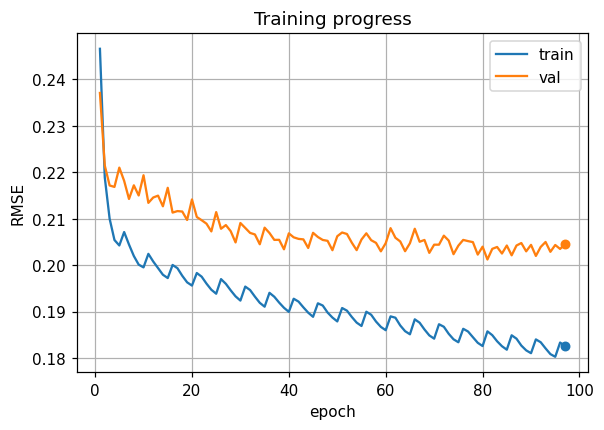

In [13]:

# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = N_FEATS,        # number of input features per minute
    short_units    = SHORT_UNITS,    # hidden size of daily LSTM
    long_units     = LONG_UNITS,     # hidden size of weekly LSTM
    dropout_short  = DROPOUT_SHORT,  # dropout after daily LSTM
    dropout_long   = DROPOUT_LONG,    # dropout after weekly LSTM
    att_heads      = ATT_HEADS,
    att_drop       = ATT_DROPOUT
)
model.to(device)   # place model parameters on GPU or CPU as specified


# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = make_optimizer_and_scheduler(
    model,
    initial_lr         = INITIAL_LR,         # starting learning rate, e.g. 3e-4
    weight_decay       = WEIGHT_DECAY,       # L2 penalty on all weights
    lr_reduce_factor   = PLATEAU_FACTOR,     # multiply LR by IT on plateau
    lr_patience        = PLATEAU_PATIENCE,   # epochs with no val‐improve before reduce
    lr_min             = MIN_LR,             # lower bound on LR
    clipnorm           = CLIPNORM            # max gradient‐norm before clipping
)


# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")


# -----------------------------------------------------------------------------
# Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse = custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = MAX_EPOCHS,
    early_stop_patience = EARLY_STOP_PATIENCE,
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device      # torch.device('cuda') or 'cpu'
)


# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
